In [652]:
import pandas as pd

In [653]:
df = pd.read_csv("Daten/masterdata_2024.csv", index_col=1, parse_dates=True)

In [654]:
df = df.apply(pd.to_numeric, errors='coerce')

In [655]:
df.drop(columns=[ "pos_neg"], inplace = True) 

In [656]:
df.set_index("zeit", inplace = True)

In [657]:
categorical = ["WRTR", "RS_IND"]

In [658]:
df.drop(columns = categorical, inplace = True)

In [659]:
df = df.dropna(how = "all", axis = 1)

In [660]:
hours = [1, 24]
def aggregate_time(df):
    for col in df:
        for h in hours:
            df[col + "_mean_{}".format(h)] = df[col].shift(1).rolling(window=h).mean()
            df[col + "_point_{}".format(h)] = df[col].shift(1)
    return df

df_agg = aggregate_time(df.drop(columns=["ecoli", "entro"]))

C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\1787327533.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_point_{}".format(h)] = df[col].shift(1)
C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\1787327533.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_mean_{}".format(h)] = df[col].shift(1).rolling(window=h).mean()
C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\1787327533.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

In [661]:
df_agg["ecoli"] = df["ecoli"]
df_agg["entro"] = df["entro"]

C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\1329968592.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg["ecoli"] = df["ecoli"]
C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\1329968592.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg["entro"] = df["entro"]


In [662]:
df_agg["regen_sum_24"] = df["R1"].shift(1).rolling(window=24).sum()
df_agg["regen_sum_48"] = df["R1"].shift(1).rolling(window=48).sum()
df_agg["regen_sum_72"] = df["R1"].shift(1).rolling(window=72).sum()
df_agg["regen_sum_96"] = df["R1"].shift(1).rolling(window=96).sum()



C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\2595700439.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg["regen_sum_24"] = df["R1"].shift(1).rolling(window=24).sum()
C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\2595700439.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg["regen_sum_48"] = df["R1"].shift(1).rolling(window=48).sum()
C:\Users\Dome Arbeit\AppData\Local\Temp\ipykernel_7412\2595700439.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [670]:
df_clean.corr()["ecoli"].sort_values(ascending = False).head(20).reset_index()

,index,ecoli
0,ecoli,1.000000
1,entro,0.961712
2,"Trübung, quantitativ_mean_24",0.759102
3,"Trübung, quantitativ_point_24",0.700583
4,"Trübung, quantitativ_point_1",0.700583
5,"Trübung, quantitativ",0.700583
6,"Trübung, quantitativ_mean_1",0.700583
7,regen_sum_96,0.501037
8,R1_mean_24,0.462559
9,regen_sum_24,0.462559


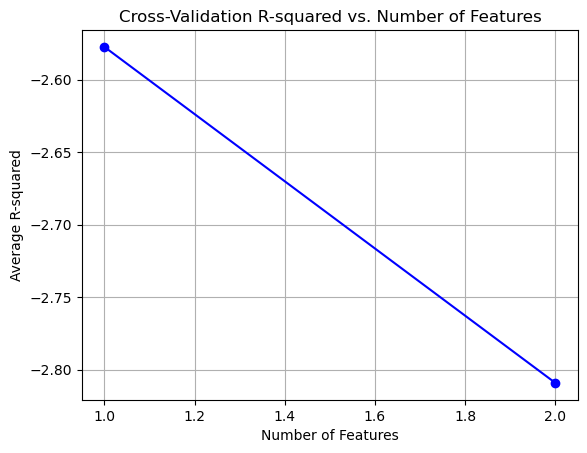

In [674]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_clean = df_agg.dropna(subset=['ecoli'])

y = df_clean['ecoli']

x = df_clean[["Trübung, quantitativ_mean_24", "ecoli", "entro", "R1"]].drop(columns = ["entro", "ecoli"])
x = x.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)


model = Ridge()

selector = RFE(model, n_features_to_select=1, step=1)  
selector = selector.fit(X_scaled, y)

cv_scores = []
num_features = []
columns = []

for n_features in range(X_scaled.shape[1], 0, -1):
    selected_features = np.where(selector.ranking_ <= n_features)[0]
    
    X_selected = X_scaled[:, selected_features]
    
    score = cross_val_score(model, X_selected, y, cv=5, scoring='r2')
    cv_scores.append(np.mean(score)) 
    columns.append(selected_features)
    num_features.append(n_features)  

# Create a DataFrame to store the results
cv_results = pd.DataFrame({
    'Number of Features': num_features,
    'Average R-squared': cv_scores
})

import matplotlib.pyplot as plt

plt.plot(num_features, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation R-squared vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Average R-squared')
plt.grid(True)
plt.show()


In [665]:
max(cv_scores)

0.6085390985608558

In [666]:
cols = df_clean.corr()["ecoli"].sort_values(ascending = False).head(20).reset_index()["index"].values

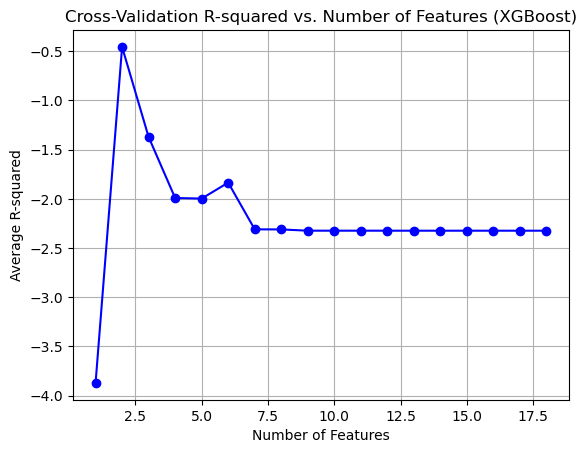

In [667]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_agg is already preprocessed and available
df_clean = df_agg.dropna(subset=['ecoli'])

y = df_clean['ecoli']
x = df_clean[cols].drop(columns=["ecoli", "entro"])
x = x.fillna(0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Perform RFE for feature selection
selector = RFE(model, n_features_to_select=1, step=1)  
selector = selector.fit(X_scaled, y)

cv_scores = []
num_features = []

# Perform cross-validation for varying numbers of features
for n_features in range(X_scaled.shape[1], 0, -1):
    selected_features = np.where(selector.ranking_ <= n_features)[0]
    X_selected = X_scaled[:, selected_features]
    
    # Evaluate using cross-validation
    score = cross_val_score(model, X_selected, y, cv=5, scoring='r2')
    cv_scores.append(np.mean(score))
    num_features.append(n_features)

# Create a DataFrame to store the results
cv_results = pd.DataFrame({
    'Number of Features': num_features,
    'Average R-squared': cv_scores
})

# Plot the results
plt.plot(num_features, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation R-squared vs. Number of Features (XGBoost)')
plt.xlabel('Number of Features')
plt.ylabel('Average R-squared')
plt.grid(True)
plt.show()
